# Podsumowanie mini projektu

### Najważniejsze pomysły
- Podział na zbiór treningowy i testowy
- Adam vs SGD jako optymalizator
- ReLU/LeakyRelU na wyjściu (nigdy nie chcemy przewidywać ujemnej liczby wypożyczeń)
- Model z kilkoma warstwami, długie trenowanie
- Skalowanie wejść/wyjść - uwaga obliczamy skalowanie (np. min/max czy mean/std na zbiorze treningowym i **te same** wartości stosujemy na zbiorze testowym

In [72]:
import torch, torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import numpy as np
import pandas as pd
import torch.utils.data as data
import seaborn as sns
import matplotlib.pyplot as plt

## Skalowanie wyjść wewnątrz sieci - batch norm
Batch-Normalization is an algorithmic method which makes the training of Deep Neural Networks (DNN) faster and more stable.  
visualisation:  
- No BN: https://miro.medium.com/v2/resize:fit:1400/format:webp/1*tcvRJN-OadhUyps6HSO0og.jpeg   
- BN: https://miro.medium.com/v2/resize:fit:1400/format:webp/1*QcSkw489NgtpaMuwDhehaQ.jpeg  

BN inaczej zachowuje się w train() i eval().

Na przykładzie z mini projektu


In [73]:
train_data = pd.read_csv("/content/data.csv",index_col=0)

In [74]:
train = train_data.drop(columns=["casual","registered","cnt","dteday","season","yr","mnth"])
train_dataset = data.TensorDataset(torch.from_numpy(train.values).float(),torch.from_numpy(train_data.values[:,-1].astype(float)).float())

In [75]:
data_loader  = data.DataLoader(train_dataset, batch_size=256, shuffle=True)

In [76]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.lin1 =nn.Linear(9, 48)  # 28 x 28 = 784
        self.act1 =nn.ReLU()
        self.lin2 =nn.Linear(48, 24)
        self.act2 =nn.ReLU()
        self.lin3 =nn.Linear(24, 1)


    def forward(self, x):
        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.act2(x)
        x = self.lin3(x)
        return x

In [77]:
class MyNetBN(nn.Module):
    def __init__(self):
        super(MyNetBN, self).__init__()
        self.lin1 =nn.Linear(9, 48)  # 28 x 28 = 784
        self.bn1 = nn.BatchNorm1d(48)
        self.act1 =nn.ReLU()
        self.lin2 =nn.Linear(48, 24)
        self.bn2 = nn.BatchNorm1d(24)
        self.act2 =nn.ReLU()
        self.lin3 =nn.Linear(24, 1)


    def forward(self, x):
        x = self.lin1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.lin3(x)
        return x

In [78]:
model = MyNet()
print(model)

MyNet(
  (lin1): Linear(in_features=9, out_features=48, bias=True)
  (act1): ReLU()
  (lin2): Linear(in_features=48, out_features=24, bias=True)
  (act2): ReLU()
  (lin3): Linear(in_features=24, out_features=1, bias=True)
)


In [79]:
model_bn = MyNetBN()
print(model_bn)

MyNetBN(
  (lin1): Linear(in_features=9, out_features=48, bias=True)
  (bn1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (lin2): Linear(in_features=48, out_features=24, bias=True)
  (bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (lin3): Linear(in_features=24, out_features=1, bias=True)
)


In [80]:
loss_fn = nn.MSELoss()
opt = optim.SGD(model.parameters(), lr=0.0001, momentum=0.5)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.0001, momentum=0.5)

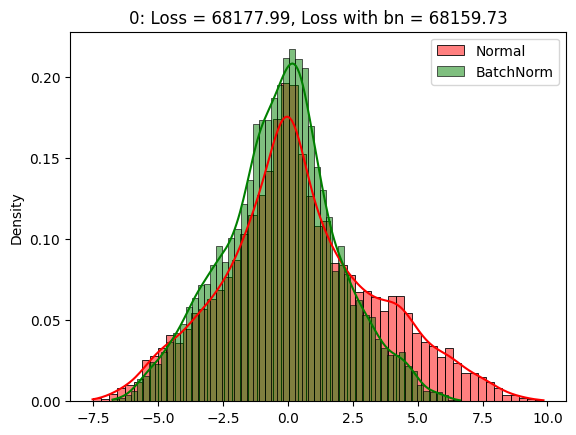

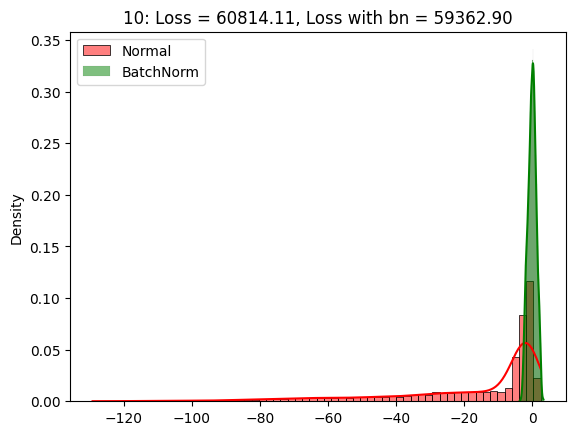

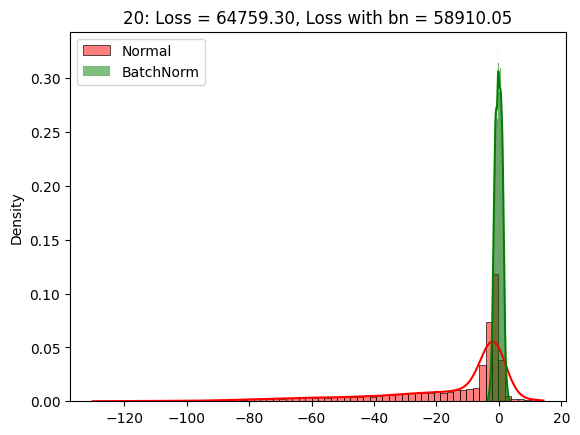

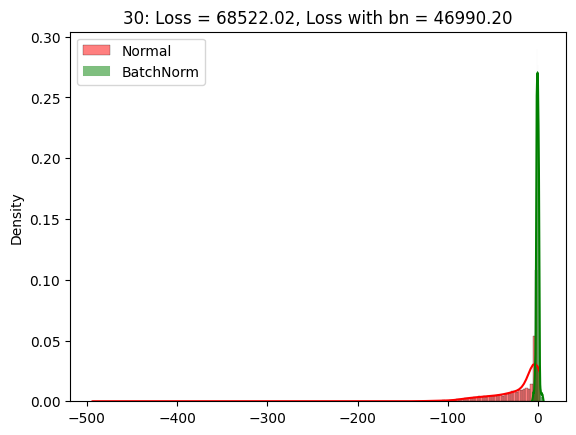

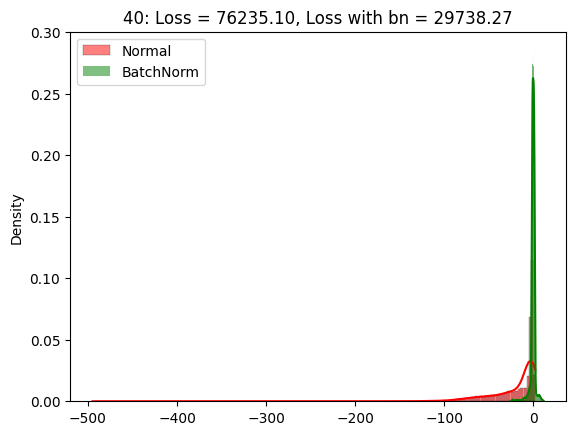

----------------------


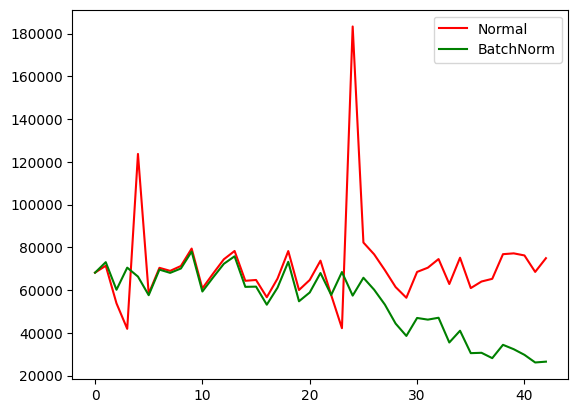

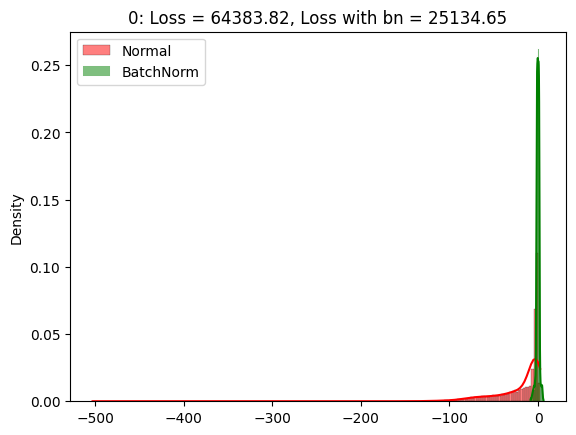

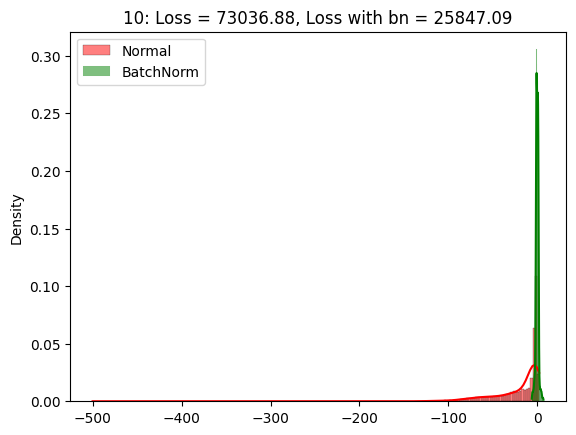

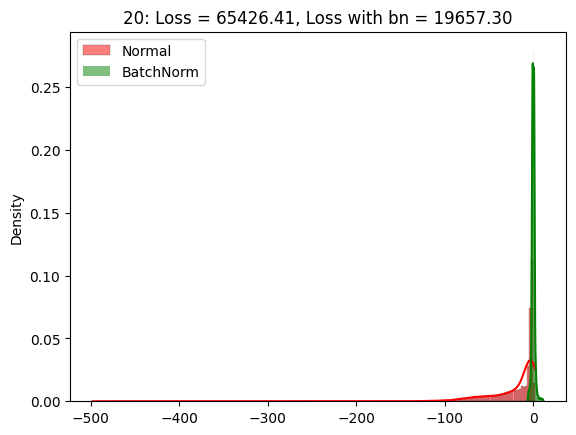

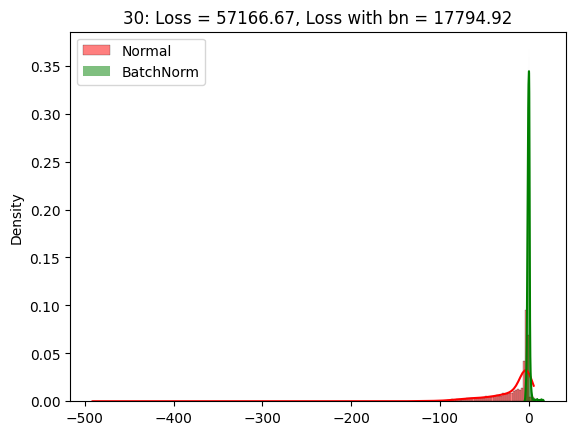

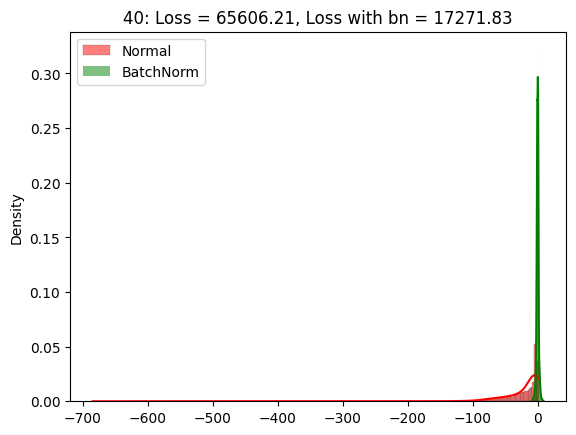

----------------------


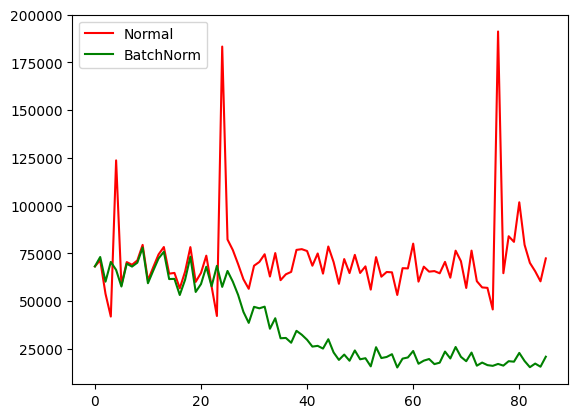

In [81]:
loss_arr = []
loss_bn_arr = []

max_epochs = 2

for epoch in range(max_epochs):
    for i, batch in enumerate(data_loader, 0):

        inputs, labels = batch

        # training steps for normal model
        opt.zero_grad()
        outputs = model(inputs).squeeze()
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        # training steps for bn model
        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs).squeeze()
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()

        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())

        if i % 10 == 0:

            inputs = inputs.view(inputs.size(0), -1)

            model.eval()
            model_bn.eval()

            a = model.lin1(inputs)
            a = a.detach().numpy().ravel()
            sns.histplot(a, kde=True, color='r', label='Normal', stat="density")

            b = model_bn.lin1(inputs)
            b = model_bn.bn1(b)
            b = b.detach().numpy().ravel()

            sns.histplot(b, kde=True, color='g', label='BatchNorm', stat="density")
            plt.title('%d: Loss = %0.2f, Loss with bn = %0.2f' % (i, loss.item(), loss_bn.item()))
            plt.legend()
            plt.show()
            plt.pause(0.5)

            model.train()
            model_bn.train()


    print('----------------------')

    plt.plot(loss_arr, 'r', label='Normal')
    plt.plot(loss_bn_arr, 'g', label='BatchNorm')
    plt.legend()
    plt.show()

## Przeuczanie sieci

In [82]:
mnist_data = torchvision.datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)
mnist_train = mnist_data[:20]
mnist_val   = mnist_data[20:1000]

In [83]:
device = torch.device("cuda")
device

device(type='cuda')

In [84]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [85]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 800)
        self.act_1 =  nn.Tanh()
        self.layer2 = nn.Linear(800, 800)
        self.act_2 = nn.Tanh()
        self.layer3 = nn.Linear(800, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.act_1(self.layer1(flattened))
        activation2 = self.act_2(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

In [86]:
def train(model, train, valid, batch_size=10, num_epochs=1, learn_rate=0.001, weight_decay=0):
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate,momentum=0.9, weight_decay=weight_decay)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
#     n = 0 # the number of iterations
    idx = 0
    for n in range(num_epochs):
        for imgs, labels in iter(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            model.train()
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()

            # save the current training information
            if idx % 10 == 9:
                iters.append(idx)
                losses.append(float(loss)/batch_size)        # compute *average* loss
                train_acc.append(get_accuracy(model, train)) # compute training accuracy
                val_acc.append(get_accuracy(model, valid))   # compute validation accuracy
            idx+=1
        if n%100==0:
            print(f"Epoch {n}")


    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()


    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


train_acc_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100)
val_acc_loader = torch.utils.data.DataLoader(mnist_val, batch_size=1000)

def get_accuracy(model, data):
    correct = 0
    total = 0
    model.eval() #*********#
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


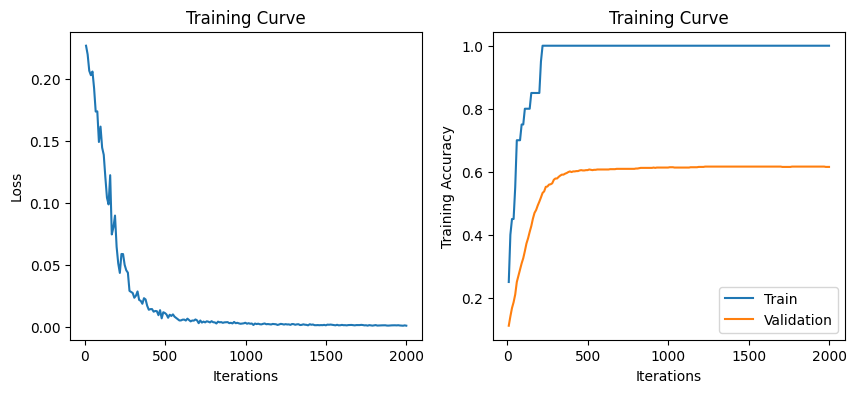

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6153061224489796


In [87]:
model = MNISTClassifier().to(device)
train(model, mnist_train, mnist_val, num_epochs=1000)

## Dropout
Maskowanie losowych neuronów w sieci.
Dropout inaczej się w train() i eval().

In [88]:
class MNISTClassifier_Dropout(nn.Module):
    def __init__(self):
        super(MNISTClassifier_Dropout, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 800)
        self.d1 = nn.Dropout(0.6)
        self.act_1 =  nn.Tanh()
        self.layer2 = nn.Linear(800, 800)
        self.d2 = nn.Dropout(0.6)
        self.act_2 = nn.Tanh()
        self.layer3 = nn.Linear(800, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.act_1(self.layer1(flattened))
        x = self.d1(activation1)
        activation2 = self.act_2(self.layer2(x))
        x = self.d2(activation2)
        output = self.layer3(x)
        return output

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


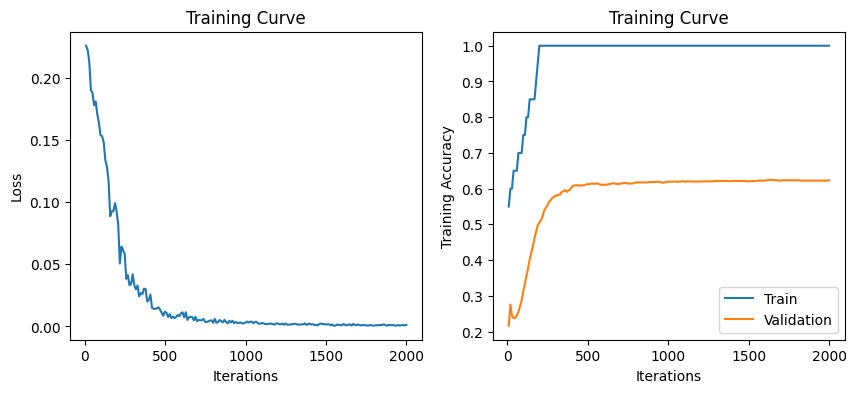

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6234693877551021


In [89]:
model = MNISTClassifier_Dropout().to(device)
train(model, mnist_train, mnist_val, num_epochs=1000)

## Weight decay
Regularyzacja zmian wag

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


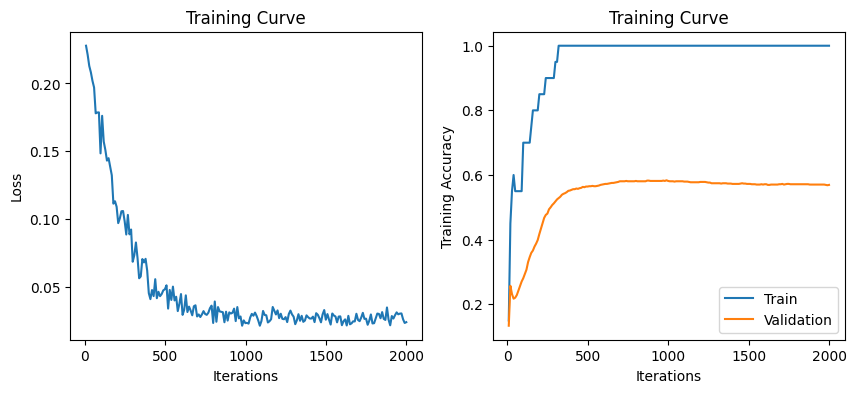

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5693877551020409


In [90]:
model = MNISTClassifier().to(device)
train(model, mnist_train, mnist_val, num_epochs=1000, weight_decay=0.1)

## Zadanie - własna regularyzacja

In [91]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 800)
        self.act_1 =  nn.Tanh()
        self.layer2 = nn.Linear(800, 800)
        self.act_2 = nn.Tanh()
        self.layer3 = nn.Linear(800, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.act_1(self.layer1(flattened))
        activation2 = self.act_2(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

In [92]:
model = MNISTClassifier().to(device)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=10, shuffle=True) # shuffle after every epoch
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


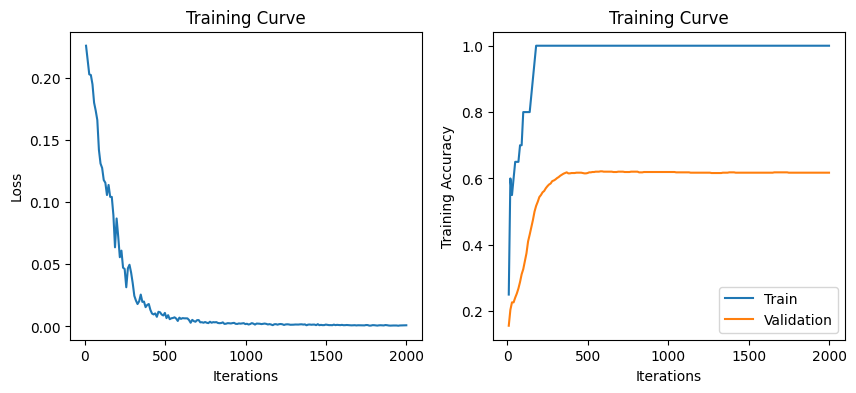

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6173469387755102


In [93]:
iters, losses, train_acc, val_acc = [], [], [], []

idx = 0
for n in range(1000):
    for imgs, labels in iter(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        model.train()
        out = model(imgs)
        ######
        # Here propose some form of regularization
        # HINT model.layer1 or list(model.parameters())

        regularization = 0

        ######
        loss = criterion(out, labels) + regularization # compute the total loss as a sum of loss + regularization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


        if idx % 10 == 9:
            iters.append(idx)
            losses.append(float(loss)/10)        # compute *average* loss
            train_acc.append(get_accuracy(model, mnist_train)) # compute training accuracy
            val_acc.append(get_accuracy(model, mnist_val))   # compute validation accuracy
        idx+=1
    if n%100==0:
        print(f"Epoch {n}")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()


print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

# Wielkość sieci a jej jakość

In [94]:
class MNISTClassifier_parametrized(nn.Module):
    def __init__(self,size_1,size_2):
        super(MNISTClassifier_parametrized, self).__init__()
        self.layer1 = nn.Linear(28 * 28, size_1)
        self.act_1 =  nn.Tanh()
        self.layer2 = nn.Linear(size_1, size_2)
        self.act_2 = nn.Tanh()
        self.layer3 = nn.Linear(size_2, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.act_1(self.layer1(flattened))
        activation2 = self.act_2(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


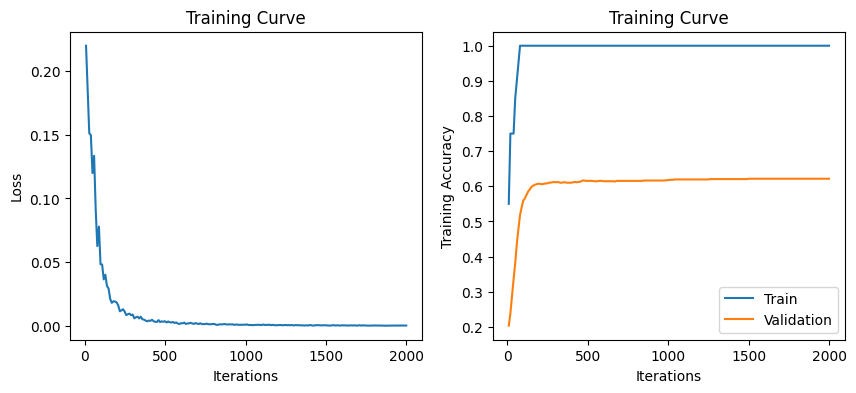

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6214285714285714


In [95]:
model = MNISTClassifier_parametrized(5000,3000).to(device)
train(model, mnist_train, mnist_val, num_epochs=1000)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


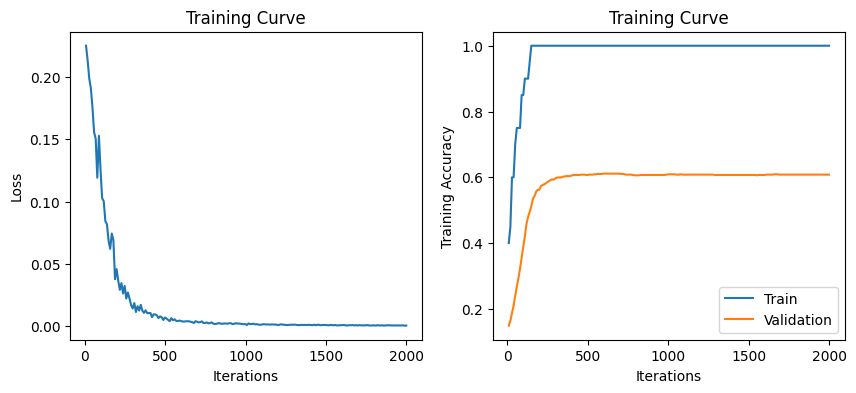

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6081632653061224


In [96]:
model = MNISTClassifier_parametrized(2000,1000).to(device)
train(model, mnist_train, mnist_val, num_epochs=1000)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


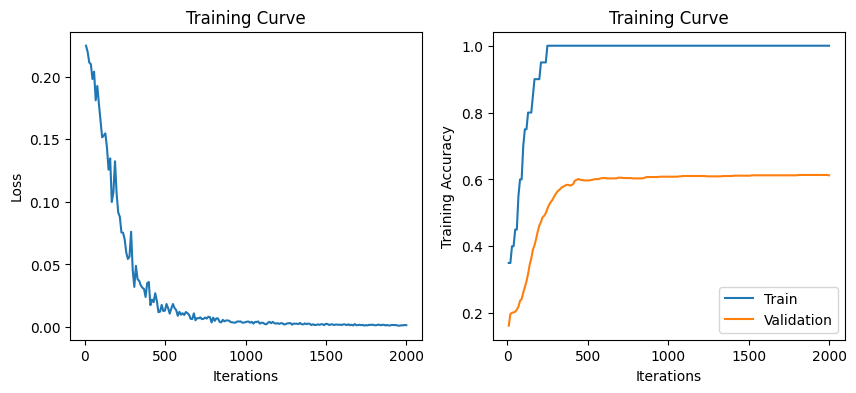

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6122448979591837


In [97]:
model = MNISTClassifier_parametrized(1000,100).to(device)
train(model, mnist_train, mnist_val, num_epochs=1000)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


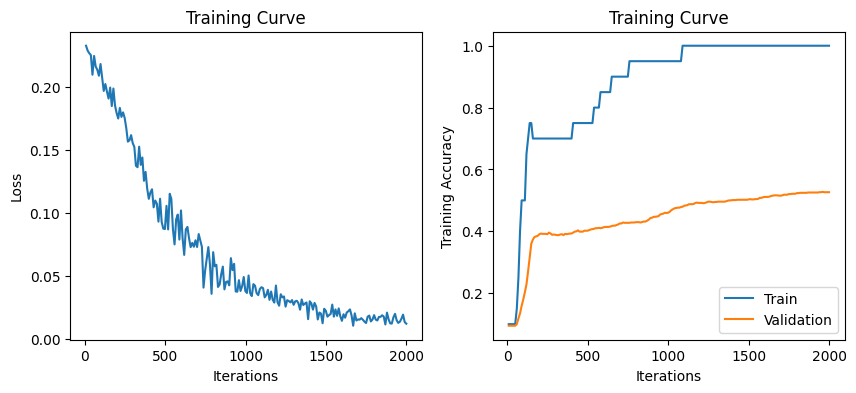

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5265306122448979


In [98]:
model = MNISTClassifier_parametrized(20,10).to(device)
train(model, mnist_train, mnist_val, num_epochs=1000)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 2100
Epoch 2200
Epoch 2300
Epoch 2400
Epoch 2500
Epoch 2600
Epoch 2700
Epoch 2800
Epoch 2900
Epoch 3000
Epoch 3100
Epoch 3200
Epoch 3300
Epoch 3400
Epoch 3500
Epoch 3600
Epoch 3700
Epoch 3800
Epoch 3900
Epoch 4000
Epoch 4100
Epoch 4200
Epoch 4300
Epoch 4400
Epoch 4500
Epoch 4600
Epoch 4700
Epoch 4800
Epoch 4900


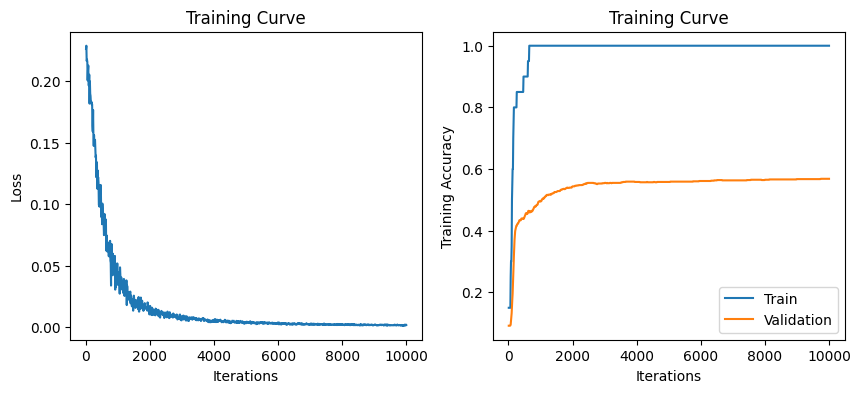

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5683673469387756


In [99]:
model = MNISTClassifier_parametrized(20,10).to(device)
train(model, mnist_train, mnist_val, num_epochs=5000)

In [102]:
def fast_accuracy(model, data):
    with torch.no_grad():
        correct = 0
        total = 0
        model.eval()
        imgs, labels = data
        output = model(imgs.to(device))
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred).to(device)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train_search(model, train, valid, batch_size=10, num_epochs=1, learn_rate=0.001, weight_decay=0):
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate,momentum=0.9, weight_decay=weight_decay)

    iters, losses, train_acc, val_acc = [], [], [], []

    idx = 0
    for n in range(num_epochs):
        for imgs, labels in iter(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            model.train()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    return(fast_accuracy(model, valid))

In [103]:
mnist_val_preprocessed = torch.cat([batch[0] for batch in mnist_val]), torch.tensor([batch[1] for batch in mnist_val])

In [104]:
mnist_data = torchvision.datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)
mnist_train = mnist_data[:20]
mnist_val   = mnist_data[20:10000]

In [105]:
first_layer = [20000, 10000, 5000, 2000, 1000, 500, 100, 50, 10]
second_layer = [20000, 10000, 5000, 2000, 1000, 500, 100, 50, 10]
results = pd.DataFrame()
for i in range(len(first_layer)):
    for j in range(len(second_layer)):
        model = MNISTClassifier_parametrized(first_layer[i],second_layer[j]).to(device)
        val_acc = train_search(model, mnist_train, mnist_val_preprocessed, num_epochs=1000)
        print(first_layer[i],second_layer[j],val_acc)
        results = results.append({"first": first_layer[i], "second": second_layer[j],"acc":val_acc},ignore_index=True)

20000 20000 0.6183673469387755


<ipython-input-105-14c511e44473>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"first": first_layer[i], "second": second_layer[j],"acc":val_acc},ignore_index=True)


20000 10000 0.6173469387755102


<ipython-input-105-14c511e44473>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"first": first_layer[i], "second": second_layer[j],"acc":val_acc},ignore_index=True)


KeyboardInterrupt: 

In [ ]:
#results.to_csv("params_search.csv",index=False)
results = pd.read_csv("params_search.csv")

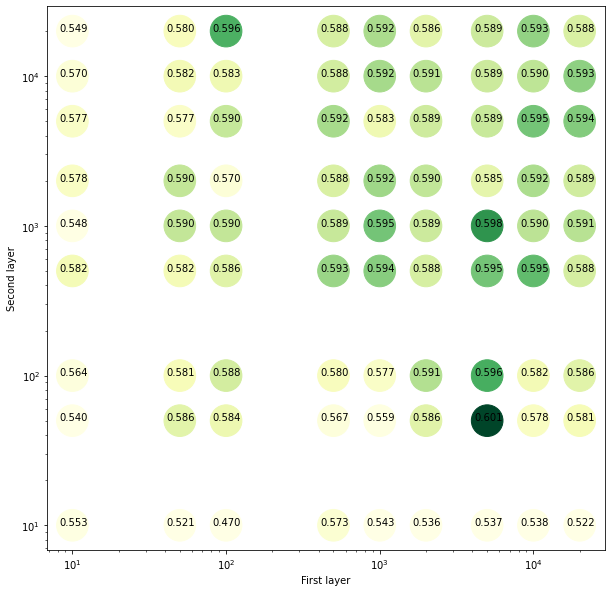

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(results["first"], results["second"], c=np.exp(results.acc*100), cmap="YlGn", s=1000)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("First layer")
plt.ylabel("Second layer")
for idx, row in results.iterrows():
    ax.annotate(str(row.acc)[:5], (row["first"]*0.82, row["second"]))
plt.show()

In [106]:
class MNISTClassifier_parametrized_3(nn.Module):
    def __init__(self,size_1,size_2, size_3):
        super(MNISTClassifier_parametrized_3, self).__init__()
        self.layer1 = nn.Linear(28 * 28, size_1)
        self.act_1 =  nn.Tanh()
        self.layer2 = nn.Linear(size_1, size_2)
        self.act_2 = nn.Tanh()
        self.layer3 = nn.Linear(size_2, size_3)
        self.act_3 = nn.Tanh()
        self.layer4 = nn.Linear(size_3, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = self.act_1(self.layer1(flattened))
        activation2 = self.act_2(self.layer2(activation1))
        activation3 = self.act_3(self.layer3(activation2))
        output = self.layer4(activation3)
        return output

## Sieć o większej liczbie warstw wymaga dłuższego treningu

Epoch 0


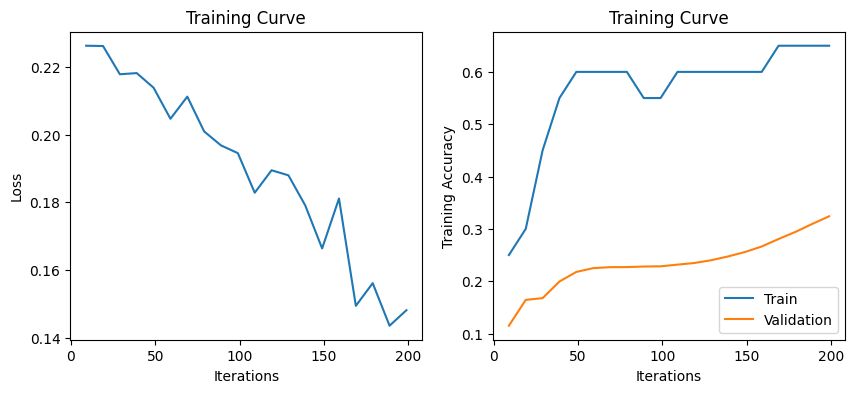

Final Training Accuracy: 0.65
Final Validation Accuracy: 0.3240480961923848


In [107]:
model = MNISTClassifier_parametrized_3(1000,500,100).to(device)
train(model, mnist_train, mnist_val, num_epochs=100)

Epoch 0


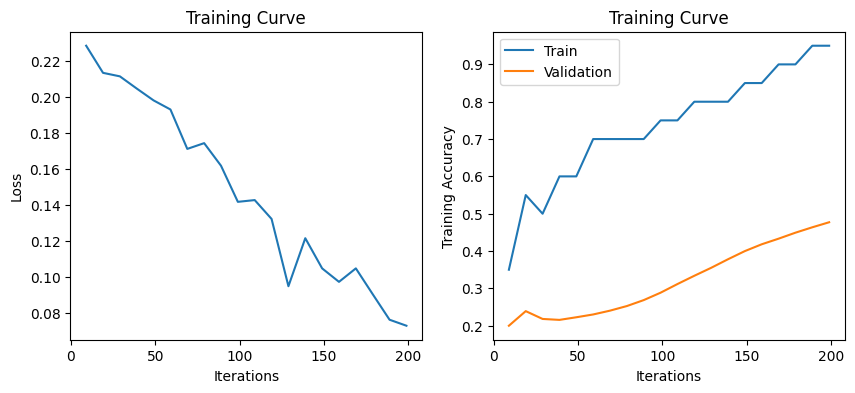

Final Training Accuracy: 0.95
Final Validation Accuracy: 0.47715430861723446


In [108]:
model = MNISTClassifier_parametrized(1000,500).to(device)
train(model, mnist_train, mnist_val, num_epochs=100)

## Większa liczba warstw może prowadzić do przeuczania

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900


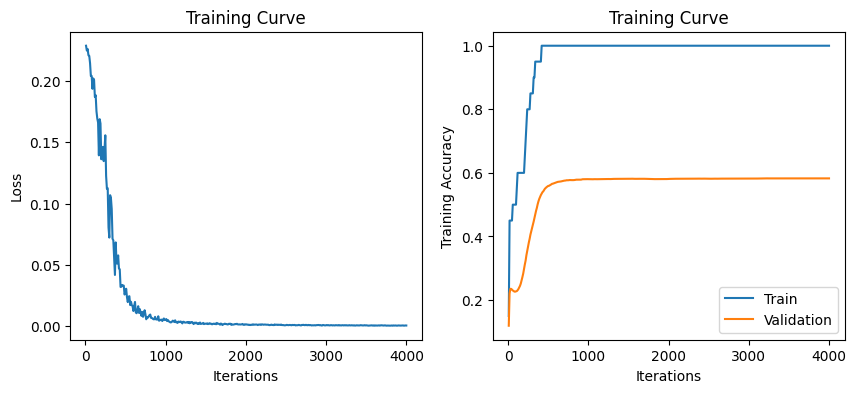

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5826653306613226


In [109]:
model = MNISTClassifier_parametrized_3(1000,500,100).to(device)
train(model, mnist_train, mnist_val, num_epochs=2000)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900


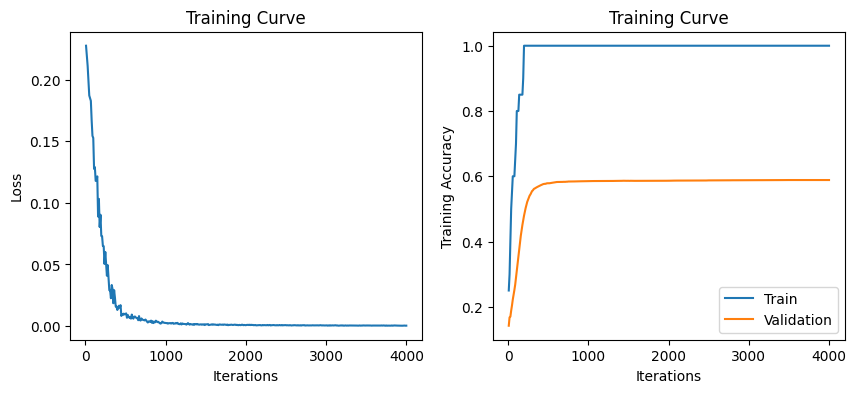

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5884769539078156


In [110]:
model = MNISTClassifier_parametrized(1000,500).to(device)
train(model, mnist_train, mnist_val, num_epochs=2000)

# Reprezentacja danych

In [111]:
adults_data_orig = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",header=None)

In [112]:
adults_data = adults_data_orig.copy()

In [113]:
adults_data.columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "label"]

In [114]:
adults_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [115]:
adults_data.drop(columns=["native-country","education","workclass","relationship", "marital-status","race"],inplace=True)

In [116]:
adults_data

,age,fnlwgt,education-num,occupation,sex,capital-gain,capital-loss,hours-per-week,label
0,39,77516,13,Adm-clerical,Male,2174,0,40,<=50K
1,50,83311,13,Exec-managerial,Male,0,0,13,<=50K
2,38,215646,9,Handlers-cleaners,Male,0,0,40,<=50K
3,53,234721,7,Handlers-cleaners,Male,0,0,40,<=50K
4,28,338409,13,Prof-specialty,Female,0,0,40,<=50K
...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,Tech-support,Female,0,0,38,<=50K
32557,40,154374,9,Machine-op-inspct,Male,0,0,40,>50K
32558,58,151910,9,Adm-clerical,Female,0,0,40,<=50K
32559,22,201490,9,Adm-clerical,Male,0,0,20,<=50K


### Get dummies

In [117]:
adults_data.sex = (adults_data.sex==' Male').astype(int)
adults_data.label = (adults_data.label==' >50K').astype(int)

In [118]:
categorical_columns = ["occupation"]
categorical_values = pd.get_dummies(adults_data[categorical_columns])
categorical_values.head()

,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [119]:
adults_data.drop(columns=categorical_columns,inplace=True)

In [120]:
train_indices = np.random.rand(len(adults_data))>0.3

In [121]:
numerical_data = torch.from_numpy(adults_data.values[train_indices,:-1]).float()
categorical_data = torch.from_numpy(categorical_values.values[train_indices]).float()
targets = torch.from_numpy(adults_data.values[train_indices,-1]).float()

test_numerical_data = torch.from_numpy(adults_data.values[~train_indices,:-1]).float()
test_categorical_data = torch.from_numpy(categorical_values.values[~train_indices]).float()
test_targets = torch.from_numpy(adults_data.values[~train_indices,-1]).float()

In [122]:
train_dataset = data.TensorDataset(numerical_data,categorical_data,targets)
test_dataset = data.TensorDataset(test_numerical_data,test_categorical_data,test_targets)

### Cat numerical and categorical data

In [123]:
class Adults_classifier(nn.Module):
    def __init__(self):
        super(Adults_classifier, self).__init__()
        self.layer1 = nn.Linear(adults_data.shape[1] + categorical_data.shape[1] -1, 40)
        self.act_1 = nn.LeakyReLU()
        self.d1 = nn.Dropout(0.4)
        self.layer2 = nn.Linear(40, 20)
        self.act_2 = nn.LeakyReLU()
        self.d2 = nn.Dropout(0.4)
        self.layer3 = nn.Linear(20, 1)
    def forward(self, x, cat_x):
        x = torch.cat([x,cat_x],dim=1)
        activation1 = self.act_1(self.layer1(x))
        activation1 = self.d1(activation1)
        activation2 = self.act_2(self.layer2(activation1))
        activation2 = self.d1(activation2)
        output = self.layer3(activation2)
        return output

In [124]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    model.eval() #*********#
    for x, cat_x, labels in data_loader:
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        output = model(x, cat_x)
        pred = output>0
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += x.shape[0]
    return correct / total

In [125]:
model = Adults_classifier().to(device)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

iters = []
losses = []
train_acc = []
val_acc = []
for n in range(10):
    epoch_losses = []
    for x, cat_x, labels in iter(train_loader):
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        model.train()
        out = model(x, cat_x).squeeze()

        loss = criterion(out, labels)
        loss.backward()
        epoch_losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)
    test_acc = get_accuracy(model, test_loader)
    print(f"Epoch {n} loss {loss_mean:.3} test_acc: {test_acc:.3}")
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
    val_acc.append(test_acc)  # compute validation accuracy


print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0 loss 1.89e+02 test_acc: 0.767
Epoch 1 loss 12.6 test_acc: 0.769
Epoch 2 loss 8.07 test_acc: 0.772
Epoch 3 loss 4.59 test_acc: 0.773
Epoch 4 loss 2.63 test_acc: 0.774
Epoch 5 loss 1.56 test_acc: 0.774
Epoch 6 loss 0.971 test_acc: 0.776
Epoch 7 loss 0.728 test_acc: 0.774
Epoch 8 loss 0.622 test_acc: 0.778
Epoch 9 loss 0.588 test_acc: 0.778
Final Training Accuracy: 0.7688221607621054
Final Validation Accuracy: 0.7779595174810877


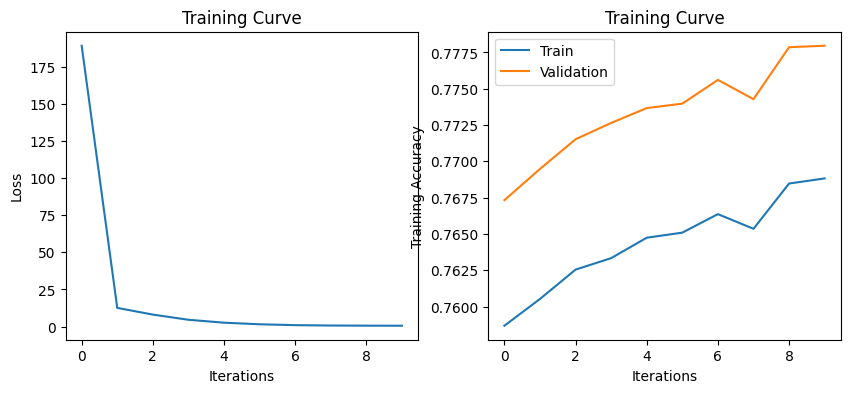

In [126]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

## Embeddingi, a później cat numerical i embedded

In [127]:
class Adults_classifier_embeddings(nn.Module):
    def __init__(self):
        super(Adults_classifier_embeddings, self).__init__()
        self.emb_layer = nn.Linear(categorical_data.shape[1], categorical_data.shape[1])
        self.act_emb = nn.Tanh()
        self.layer1 = nn.Linear(adults_data.shape[1] -1 + categorical_data.shape[1], 40)
        self.act_1 =  nn.LeakyReLU()
        self.d1 = nn.Dropout(0.4)
        self.layer2 = nn.Linear(40, 20)
        self.act_2 =  nn.LeakyReLU()
        self.d2 = nn.Dropout(0.4)
        self.layer3 = nn.Linear(20, 1)
    def forward(self, x, cat_x):
        cat_x_embedded = self.emb_layer(cat_x)
        cat_x_embedded = self.act_emb(cat_x_embedded)
        x = torch.cat([x,cat_x_embedded],dim=1)
        activation1 = self.act_1(self.layer1(x))
        activation1 = self.d1(activation1)
        activation2 = self.act_2(self.layer2(activation1))
        activation2 = self.d2(activation2)
        output = self.layer3(activation2)
        return output

In [128]:
model = Adults_classifier_embeddings().to(device)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

iters = []
losses = []
train_acc = []
val_acc = []
for n in range(10):
    epoch_losses = []
    for x, cat_x, labels in iter(train_loader):
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        model.train()
        out = model(x, cat_x).squeeze()

        loss = criterion(out, labels)
        loss.backward()
        epoch_losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)
    test_acc = get_accuracy(model, test_loader)
    print(f"Epoch {n} loss {loss_mean:.3} test_acc: {test_acc:.3}")
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
    val_acc.append(test_acc)  # compute validation accuracy


print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0 loss 2.84e+02 test_acc: 0.773
Epoch 1 loss 15.0 test_acc: 0.772
Epoch 2 loss 9.21 test_acc: 0.773
Epoch 3 loss 6.67 test_acc: 0.773
Epoch 4 loss 4.28 test_acc: 0.776
Epoch 5 loss 2.81 test_acc: 0.777
Epoch 6 loss 1.77 test_acc: 0.779
Epoch 7 loss 1.12 test_acc: 0.776
Epoch 8 loss 0.806 test_acc: 0.773
Epoch 9 loss 0.651 test_acc: 0.774
Final Training Accuracy: 0.7651784538390622
Final Validation Accuracy: 0.7741770599059496


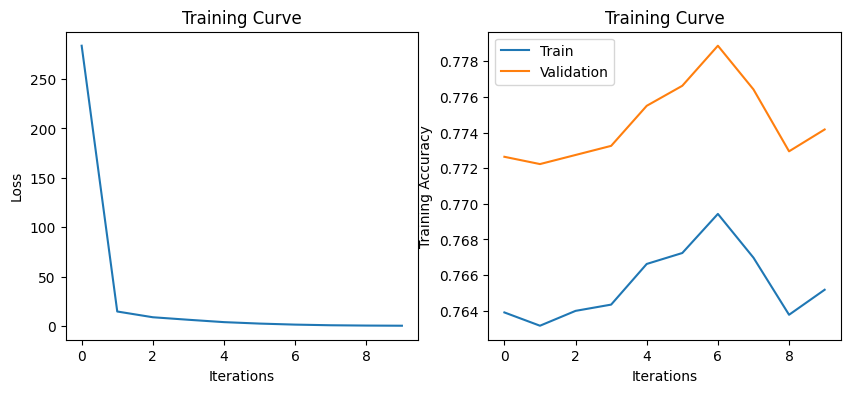

In [129]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

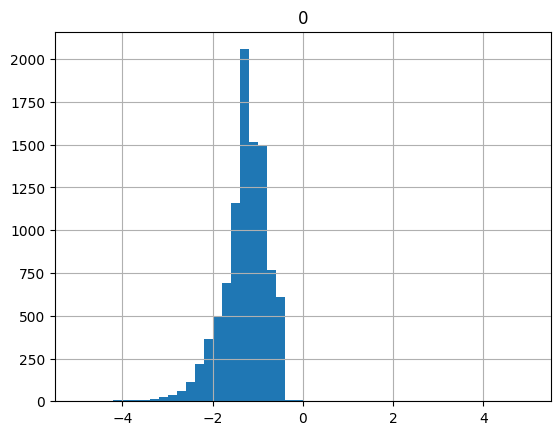

In [130]:
preds = model(test_numerical_data.to(device),test_categorical_data.to(device))
pd.DataFrame(preds.cpu().detach().numpy()).hist(bins=50, range=(-5,5));

In [131]:
(preds>0).sum()

tensor(99, device='cuda:0')

# Ważenie przykładów

In [132]:
model = Adults_classifier_embeddings().to(device)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
criterion = nn.BCEWithLogitsLoss(pos_weight=(len(targets)-sum(targets))/sum(targets))
optimizer = optim.Adam(model.parameters(), lr=0.001)

iters = []
losses = []
train_acc = []
val_acc = []
for n in range(30):
    epoch_losses = []
    for x, cat_x, labels in iter(train_loader):
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        model.train()
        out = model(x, cat_x).squeeze()

        loss = criterion(out, labels)
        loss.backward()
        epoch_losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

    loss_mean = np.array(epoch_losses).mean()
    iters.append(n)
    losses.append(loss_mean)
    test_acc = get_accuracy(model, test_loader)
    print(f"Epoch {n} loss {loss_mean:.3} test_acc: {test_acc:.3}")
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
    val_acc.append(test_acc)  # compute validation accuracy


print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0 loss 4.03e+02 test_acc: 0.769
Epoch 1 loss 24.6 test_acc: 0.786
Epoch 2 loss 14.9 test_acc: 0.788
Epoch 3 loss 9.22 test_acc: 0.652
Epoch 4 loss 5.67 test_acc: 0.794
Epoch 5 loss 3.59 test_acc: 0.788
Epoch 6 loss 2.3 test_acc: 0.241
Epoch 7 loss 1.65 test_acc: 0.792
Epoch 8 loss 1.33 test_acc: 0.798
Epoch 9 loss 1.17 test_acc: 0.3
Epoch 10 loss 1.09 test_acc: 0.666
Epoch 11 loss 1.04 test_acc: 0.791
Epoch 12 loss 1.03 test_acc: 0.795
Epoch 13 loss 1.02 test_acc: 0.792
Epoch 14 loss 1.01 test_acc: 0.793
Epoch 15 loss 1.01 test_acc: 0.796
Epoch 16 loss 1.09 test_acc: 0.794
Epoch 17 loss 1.03 test_acc: 0.795
Epoch 18 loss 1.0 test_acc: 0.791
Epoch 19 loss 1.0 test_acc: 0.632
Epoch 20 loss 1.09 test_acc: 0.791
Epoch 21 loss 0.997 test_acc: 0.791
Epoch 22 loss 0.98 test_acc: 0.787
Epoch 23 loss 0.975 test_acc: 0.795
Epoch 24 loss 0.974 test_acc: 0.786
Epoch 25 loss 1.01 test_acc: 0.793
Epoch 26 loss 0.991 test_acc: 0.789
Epoch 27 loss 0.983 test_acc: 0.795
Epoch 28 loss 0.971 test_a

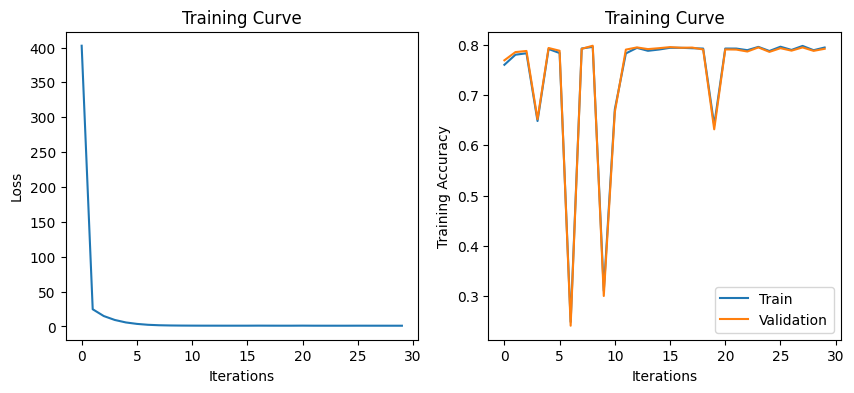

In [133]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

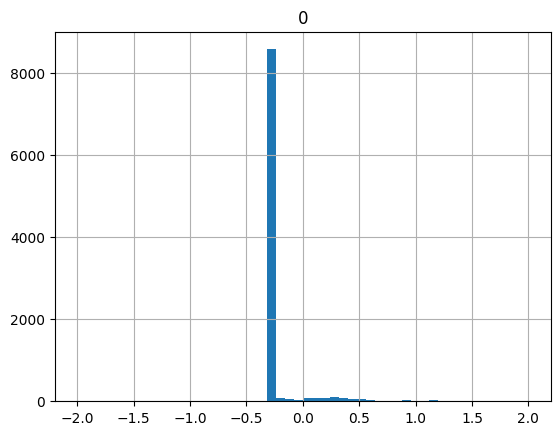

In [134]:
preds = model(test_numerical_data.to(device),test_categorical_data.to(device))
pd.DataFrame(preds.cpu().detach().numpy()).hist(bins=50, range=(-2,2));

In [135]:
(preds>0).sum()

tensor(1042, device='cuda:0')